Graph loaded with 1500 nodes and 6600 edges


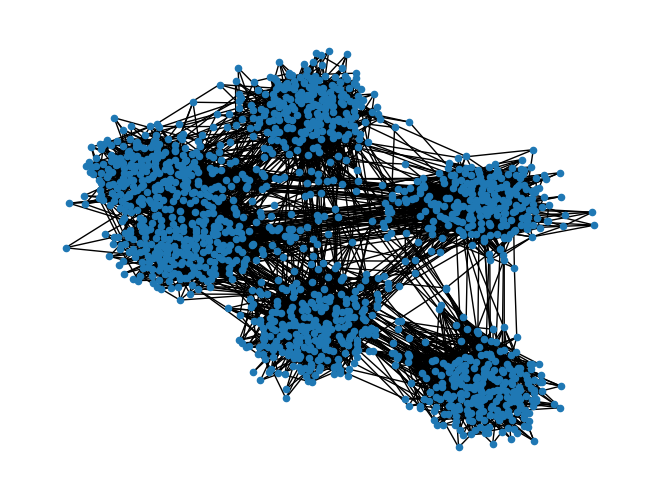

In [2]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from sklearn.model_selection import train_test_split

path = "./assignment2_files_2025/edges_train.edgelist"

G = nx.read_edgelist(path, delimiter=',', nodetype=int, create_using=nx.Graph())

print(f"Graph loaded with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos=pos, node_size=20, with_labels=False)
plt.show()


In [5]:
from networkx.algorithms.community import greedy_modularity_communities

#the function will return a partition of nodes
c = list(greedy_modularity_communities(G, resolution=0.8))

print(c)
#we can inspecte the first element of the partition (e.g., nodes on community 1)
sorted(c[0])
len(c)

[frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219

5

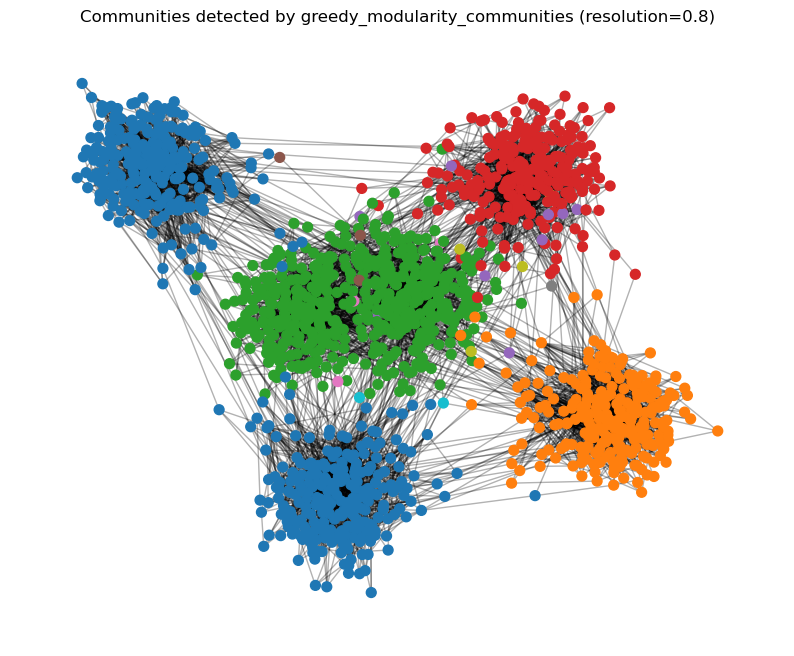

In [12]:
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms.community import greedy_modularity_communities

# Detect communities
c = list(greedy_modularity_communities(G, resolution=2.5))

# Create a dictionary that maps each node to its community index
community_map = {}
for i, community in enumerate(c):
    for node in community:
        community_map[node] = i

# Assign colors to nodes based on their community
node_colors = [community_map[node] for node in G.nodes()]

# Draw the network
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=15)  # layout for better visualization
nx.draw_networkx_nodes(G, pos, node_color=node_colors, cmap=plt.cm.tab10, node_size=50)
nx.draw_networkx_edges(G, pos, alpha=0.3)
plt.title("Communities detected by greedy_modularity_communities (resolution=0.8)")
plt.axis("off")
plt.show()


In [19]:
import pandas as pd
edges = []
for edg in nx.edges(G):
    edges.append(edg)

dfEdges = pd.DataFrame(edges)
dfEdges.to_csv("edges_train.edgelist", index=False, header=False)


In [13]:
# Generate features from edge endpoints
# Input: getFeature(graph, node_i, node_j)
N = len(list(G.nodes))
pa = np.zeros((N,N))

preds = nx.preferential_attachment(G, [(i,j) for i in range(N) for j in range(N)])
for u, v, p in preds:
    pa[u,v] = p
    
def getFeature(G, i, j): 
    # Example node-level features
    deg_i = G.degree(i)
    deg_j = G.degree(j)
    cc_i = nx.clustering(G, i)
    cc_j = nx.clustering(G, j)
    
    # Preferential attachment feature (from precomputed matrix)
    pa_ij = pa[i, j]
    
    # You can add more features here if needed
    return np.array([deg_i, deg_j, cc_i, cc_j, pa_ij])


In [14]:
# Let us now create a training set where X will correspond to features for each possible edge and Y the predciton
X = []
Y = []

# Add positive examples where edge exist
for (i, j) in G.edges:
    X.append(getFeature(G, i, j))
    Y.append(1)

# Add negative examples where edge does not exist
# Reflect: how many negative examples should you include?
for kk in range(200):
        i = np.random.randint(N)
        j = np.random.randint(N)

        while G.has_edge(i,j) or i == j:
            i = np.random.randint(N)
            j = np.random.randint(N)

        X.append(getFeature(G, i, j))
        Y.append(0)
        
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.8, random_state = 42)

In [15]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

clf = LogisticRegression(random_state=0, C=2.0)
clf.fit(X_train, y_train)

scores = cross_val_score(clf, X_test, y_test, cv=5)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.97 accuracy with a standard deviation of 0.00


In [21]:
# Return Solution
import pandas as pd
inpTest = pd.read_csv('solutionInput.csv', sep=',', index_col="ID")
inpTest = np.array(inpTest)
inp = []

for i in inpTest:
    inp.append(getFeature(G, i[0], i[1]))

# Convert to numpy array
inp = np.array(inp)

# Predict using trained Logistic Regression model
predictionsLR = clf.predict(inp)

pd.DataFrame(predictionsLR).to_csv('solutionInput.csv', index=True, header=["prediction"], index_label="ID")

In [22]:
# Evaluate solution

# Read predictions
y_pred = pd.read_csv('solutionInput.csv', sep=',', index_col="ID")
y_pred = np.array(y_pred)

# Read solutions file
y = pd.read_csv('solutionInput.csv', sep=',', index_col="ID")
y = np.array(y)

# Calculate accuracy
accuracy = accuracy_score(y, y_pred)
print("Accuracy (test): %0.3f%% " % (accuracy * 100))

Accuracy (test): 100.000% 
